In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import contingency_matrix

In [11]:
class kohonen:

    def __init__(
        self,
        M,
        N,
        X,
        learning_rate=0.1,
        gauss_neighborhood_function=True,
        neighborhood_proximity=1.0,
        lattice="rectangular",
    ):
        self.M = M
        self.N = N
        self.learning_rate = learning_rate
        self.input_dim = X.shape[1]
        if gauss_neighborhood_function:
            self.neighborhood_function = self.gauss_neighborhood
        else:
            self.neighborhood_function = self.mexican_hat_neighborhood
        self.neighborhood_proximity = neighborhood_proximity
        self.lattice = lattice
        self.index_array = np.array(
            [
                np.arange(M).repeat(N).reshape(M, N),
                np.arange(N).repeat(M).reshape(N, M).T,
            ],
            dtype=float,
        )
        if lattice == "hexagonal":
            self.index_array[0] = self.index_array[0] * np.sqrt(3) / 2
            self.index_array[1][1::2] += 0.5

        # weights initialization
        self.weights = np.random.uniform(0, 1, (self.input_dim, M, N))
        minimum = np.min(X, axis=0)
        maximum = np.max(X, axis=0)
        for i in range(self.input_dim):
            self.weights[i] = minimum[i] + (maximum[i] - minimum[i]) * self.weights[i]

    def gauss_neighborhood(self, distance, epoch):
        return np.exp(-np.power(distance * epoch * self.neighborhood_proximity, 2))

    def mexican_hat_neighborhood(self, distance, epoch):
        return np.exp(-np.power(distance * epoch * self.neighborhood_proximity, 2)) * (
            2 - 4 * np.power(distance * epoch * self.neighborhood_proximity, 2)
        )

    def euclidean_distance(self, x, y):
        return np.linalg.norm(x - y)

    def decay(self, t, iteration_num):
        return self.learning_rate * np.exp(-t / iteration_num)

    def train(self, X, max_epochs, use_cache=True, verbose=True):
        cache = {}
        for epoch in range(max_epochs):
            X = np.random.permutation(X)
            decay_value = self.decay(epoch, max_epochs)
            for x in X:
                # finding the best matching unit (index of the neuron with the smallest distance to the input vector x)
                idx = np.argmin(np.linalg.norm(self.weights.T - x, axis=2).T)
                bmu = np.unravel_index(idx, self.weights[0].shape)
                bmu = self.index_array[:, bmu[0], bmu[1]]

                # updating weights
                if use_cache:
                    if tuple(bmu) not in cache:
                        cache[tuple(bmu)] = np.linalg.norm(
                            (self.index_array.T - np.array(bmu)),
                            axis=2,
                        ).T
                    distance_on_lattice_matrix = cache[tuple(bmu)]
                else:
                    distance_on_lattice_matrix = np.linalg.norm(
                        (self.index_array.T - np.array(bmu)),
                        axis=2,
                    ).T
                neighborhood = self.neighborhood_function(
                    distance_on_lattice_matrix, epoch
                )
                self.weights += decay_value * neighborhood * (x - self.weights.T).T
            if verbose and epoch % 10 == 0:
                print(f"Epoch: {epoch}")

    def predict(self, X):
        return np.array(
            [
                [
                    np.argmin(
                        [
                            self.euclidean_distance(x, self.weights[:, i, j])
                            for i in range(self.M)
                            for j in range(self.N)
                        ]
                    )
                    for x in X
                ]
            ]
        ).T

In [8]:
class kohonen_old:

    def __init__(
        self,
        M,
        N,
        X,
        learning_rate=0.1,
        neighborhood_function="gauss",
        neighborhood_proximity=1.0,
    ):
        self.M = M
        self.N = N
        self.learning_rate = learning_rate
        self.input_dim = X.shape[1]
        self.neighborhood_function = neighborhood_function
        self.neighborhood_proximity = neighborhood_proximity
        self.weights = np.random.uniform(0, 1, (self.input_dim, M, N))
        minimum = np.min(X, axis=0)
        maximum = np.max(X, axis=0)
        for i in range(self.input_dim):
            self.weights[i] = minimum[i] + (maximum[i] - minimum[i]) * self.weights[i]

    def gauss_neighborhood(self, t, T):
        return np.exp(-np.power(t * T * self.neighborhood_proximity, 2))

    def mexican_hat_neighborhood(self, t, T):
        return np.exp(-np.power(t * T * self.neighborhood_proximity, 2)) * (
            2 - 4 * np.power(t * T * self.neighborhood_proximity, 2)
        )

    def euclidean_distance(self, x, y):
        return np.linalg.norm(x - y)

    def slow_down(self, t, iteration_num):
        return self.learning_rate * np.exp(-t / iteration_num)

    def train(self, X, max_epochs):
        for epoch in range(max_epochs):
            X = np.random.permutation(X)
            for x in X:
                bmu = None
                bmu_distance = np.inf
                for i in range(self.M):
                    for j in range(self.N):
                        distance = self.euclidean_distance(x, self.weights[:, i, j])
                        if distance < bmu_distance:
                            bmu_distance = distance
                            bmu = (i, j)

                for i in range(self.M):
                    for j in range(self.N):
                        distance = self.euclidean_distance(
                            np.array(bmu), np.array([i, j])
                        )
                        if self.neighborhood_function == "gauss":
                            self.weights[:, i, j] += (
                                self.slow_down(epoch, max_epochs)
                                * self.gauss_neighborhood(distance, epoch)
                                * (x - self.weights[:, i, j])
                            )
                        elif self.neighborhood_function == "mexican_hat":
                            self.weights[:, i, j] += (
                                self.slow_down(epoch, max_epochs)
                                * self.mexican_hat_neighborhood(distance, epoch)
                                * (x - self.weights[:, i, j])
                            )
                        else:
                            raise ValueError("Invalid neighborhood function")

    def predict(self, X):
        return np.array(
            [
                [
                    np.argmin(
                        [
                            self.euclidean_distance(x, self.weights[:, i, j])
                            for i in range(self.M)
                            for j in range(self.N)
                        ]
                    )
                    for x in X
                ]
            ]
        ).T

## tests with numpy and speed 

### First loop

In [9]:
cube = pd.read_csv("./../data/kohonen/cube.csv")
cube_x = cube.drop("c", axis=1).to_numpy()
kohon = kohonen(2, 4, cube_x)
weights = kohon.weights
weights

array([[[-0.54516675,  1.83357348,  0.89715934,  3.3402832 ],
        [ 3.12092602,  4.61348784,  2.22629843,  1.90697835]],

       [[ 2.78590425,  2.99622761,  4.61099138,  4.83017394],
        [-0.11398586,  0.74772246,  1.8560575 ,  5.46295191]],

       [[ 3.24254342,  3.29784367,  3.45380848,  1.48074994],
        [-0.42069434,  1.87419066,  0.92747865,  1.21113898]]])

In [8]:
x = cube_x[40]
for i in range(2):
    for j in range(4):
        distance = kohon.euclidean_distance(x, weights[:, i, j])
        print(f"Distance from {i}, {j}: {distance}")

Distance from 0, 0: 2.969196254442665
Distance from 0, 1: 7.122040734283995
Distance from 0, 2: 6.605874697964391
Distance from 0, 3: 5.500386484672707
Distance from 1, 0: 5.537161597578338
Distance from 1, 1: 3.1911140646585654
Distance from 1, 2: 3.756154118125423
Distance from 1, 3: 6.244266546847295


In [9]:
np.linalg.norm(weights.T - x, axis=2).T

array([[2.96919625, 7.12204073, 6.6058747 , 5.50038648],
       [5.5371616 , 3.19111406, 3.75615412, 6.24426655]])

In [10]:
idx = np.argmin(np.linalg.norm(weights.T - x, axis=2).T)
np.unravel_index(idx, weights[0].shape)

(0, 0)

#### Testing if i broke something 

In [11]:
kohon = kohonen(2, 4, cube_x)
kohon.train(cube_x, 10)
cube["predicted"] = kohon.predict(cube_x)
v_measure_score(cube["c"], cube["predicted"])

[[2.23606798 1.41421356 1.         1.41421356]
 [2.         1.         0.         1.        ]]

[[2.         1.         0.         1.        ]
 [2.23606798 1.41421356 1.         1.41421356]]

[[2.         1.         0.         1.        ]
 [2.23606798 1.41421356 1.         1.41421356]]

[[2.23606798 1.41421356 1.         1.41421356]
 [2.         1.         0.         1.        ]]

[[3.         2.         1.         0.        ]
 [3.16227766 2.23606798 1.41421356 1.        ]]

[[3.16227766 2.23606798 1.41421356 1.        ]
 [3.         2.         1.         0.        ]]

[[3.16227766 2.23606798 1.41421356 1.        ]
 [3.         2.         1.         0.        ]]

[[1.         1.41421356 2.23606798 3.16227766]
 [0.         1.         2.         3.        ]]

[[3.16227766 2.23606798 1.41421356 1.        ]
 [3.         2.         1.         0.        ]]

[[3.16227766 2.23606798 1.41421356 1.        ]
 [3.         2.         1.         0.        ]]

[[0.         1.         2.         3.   

0.9121824333611196

### Getting rid of second loop

In [12]:
bmu = (0, 1)
for i in range(2):
    for j in range(4):
        distance_on_lattice = kohon.euclidean_distance(
            np.array(bmu), np.array([i, j])  # old approach change it
        )
        print(f"Distance from {i}, {j}: {distance_on_lattice}")

Distance from 0, 0: 1.0
Distance from 0, 1: 0.0
Distance from 0, 2: 1.0
Distance from 0, 3: 2.0
Distance from 1, 0: 1.4142135623730951
Distance from 1, 1: 1.0
Distance from 1, 2: 1.4142135623730951
Distance from 1, 3: 2.23606797749979


In [13]:
# create a matrix of distances from the BMU without looping
bmu = (0, 1)
np.arange(4).repeat(2).reshape(4, 2).T

array([[0, 1, 2, 3],
       [0, 1, 2, 3]])

In [14]:
np.arange(2).repeat(4).reshape(2, 4)

array([[0, 0, 0, 0],
       [1, 1, 1, 1]])

In [15]:
# create a 3d numpy array with the two above arrays
(
    np.array(
        [np.arange(4).repeat(2).reshape(4, 2).T, np.arange(2).repeat(4).reshape(2, 4)]
    ).T
    - np.array(bmu)
).T

array([[[ 0,  1,  2,  3],
        [ 0,  1,  2,  3]],

       [[-1, -1, -1, -1],
        [ 0,  0,  0,  0]]])

In [56]:
c = np.array(
    [
        np.arange(M).repeat(N).reshape(M, N),
        np.arange(N).repeat(M).reshape(N, M).T,
    ]
)
tuple(c[:, 1, 0])

(1, 0)

In [16]:
bmu = (0, 1)
M = 4
N = 5
distance_matrix = np.linalg.norm(
    (
        np.array(
            [
                np.arange(N).repeat(M).reshape(N, M).T,
                np.arange(M).repeat(N).reshape(M, N),
            ]
        ).T
        - np.flip(np.array(bmu))
    ),
    axis=2,
).T
distance_matrix

array([[1.        , 0.        , 1.        , 2.        , 3.        ],
       [1.41421356, 1.        , 1.41421356, 2.23606798, 3.16227766],
       [2.23606798, 2.        , 2.23606798, 2.82842712, 3.60555128],
       [3.16227766, 3.        , 3.16227766, 3.60555128, 4.24264069]])

In [17]:
neighborhood = kohon.gauss_neighborhood(distance_matrix, 1)
neighborhood

array([[3.67879441e-01, 1.00000000e+00, 3.67879441e-01, 1.83156389e-02,
        1.23409804e-04],
       [1.35335283e-01, 3.67879441e-01, 1.35335283e-01, 6.73794700e-03,
        4.53999298e-05],
       [6.73794700e-03, 1.83156389e-02, 6.73794700e-03, 3.35462628e-04,
        2.26032941e-06],
       [4.53999298e-05, 1.23409804e-04, 4.53999298e-05, 2.26032941e-06,
        1.52299797e-08]])

### "Last element" 

In [18]:
kohon = kohonen(M, N, cube_x)
weights = kohon.weights
x = cube_x[0]
for i in range(M):
    for j in range(N):
        print(neighborhood[i, j] * (x - weights[:, i, j]))

[ 0.44563549 -1.24178955  0.73149393]
[ 1.90805638 -4.05334594  1.95819208]
[-0.31186926 -1.66765282 -0.87354471]
[ 0.01286617 -0.03492739 -0.03578102]
[-7.44478226e-05 -6.01789755e-05  1.95225876e-04]
[-0.61717668 -0.38603302  0.07343881]
[-0.22112384  0.82582942  0.6969343 ]
[ 0.24993176 -0.44811843 -0.20915958]
[ 0.00176321 -0.01993991  0.0003693 ]
[-1.36256327e-04 -8.98594152e-05 -4.09370414e-05]
[-0.00202372 -0.01594956  0.01345532]
[-0.00657182  0.03609782 -0.02519585]
[-0.0216336  -0.00525382 -0.00687062]
[ 5.23405298e-05  5.17388471e-04 -1.07854607e-03]
[-9.93064413e-06  5.45489954e-06  3.31209899e-07]
[-1.35417743e-04 -1.15194110e-04 -1.01746292e-05]
[-0.00056206  0.00018316  0.00018267]
[-8.24439863e-05  6.93347075e-05 -4.15650528e-05]
[-5.62775245e-06  4.54325272e-06 -4.82384656e-06]
[-7.25636842e-08 -2.36158828e-08 -5.00446713e-09]


In [19]:
neighborhood * (x - weights.T).T

array([[[ 4.45635488e-01,  1.90805638e+00, -3.11869261e-01,
          1.28661720e-02, -7.44478226e-05],
        [-6.17176676e-01, -2.21123840e-01,  2.49931759e-01,
          1.76321099e-03, -1.36256327e-04],
        [-2.02371996e-03, -6.57182292e-03, -2.16335971e-02,
          5.23405298e-05, -9.93064413e-06],
        [-1.35417743e-04, -5.62058348e-04, -8.24439863e-05,
         -5.62775245e-06, -7.25636842e-08]],

       [[-1.24178955e+00, -4.05334594e+00, -1.66765282e+00,
         -3.49273875e-02, -6.01789755e-05],
        [-3.86033017e-01,  8.25829420e-01, -4.48118428e-01,
         -1.99399104e-02, -8.98594152e-05],
        [-1.59495558e-02,  3.60978196e-02, -5.25382259e-03,
          5.17388471e-04,  5.45489954e-06],
        [-1.15194110e-04,  1.83155405e-04,  6.93347075e-05,
          4.54325272e-06, -2.36158828e-08]],

       [[ 7.31493932e-01,  1.95819208e+00, -8.73544714e-01,
         -3.57810154e-02,  1.95225876e-04],
        [ 7.34388100e-02,  6.96934299e-01, -2.09159581e-01,


In [176]:
kohon = kohonen(2, 4, cube_x)
kohon.train(cube_x, 100)
cube["predicted"] = kohon.predict(cube_x)
v_measure_score(cube["c"], cube["predicted"])

0.9155834502607125

## Actual KOH2

In [43]:
def plot_lattice_grid(network):
    plt.figure(figsize=(10, 10))
    for i in range(network.M):
        for j in range(network.N):
            plt.plot(
                network.index_array[1, i, j],
                network.index_array[0, i, j],
                "bo",
                markersize=15,
                zorder=100,
            )

            if i > 0:
                plt.plot(
                    [network.index_array[1, i, j], network.index_array[1, i - 1, j]],
                    [network.index_array[0, i, j], network.index_array[0, i - 1, j]],
                    "k--",
                )
            if j > 0:
                plt.plot(
                    [network.index_array[1, i, j], network.index_array[1, i, j - 1]],
                    [network.index_array[0, i, j], network.index_array[0, i, j - 1]],
                    "k--",
                )
            if network.lattice == "hexagonal":
                if i % 2 == 0 and j > 0 and i > 0:
                    plt.plot(
                        [
                            network.index_array[1, i, j],
                            network.index_array[1, i - 1, j - 1],
                        ],
                        [
                            network.index_array[0, i, j],
                            network.index_array[0, i - 1, j - 1],
                        ],
                        "k--",
                    )
                elif i % 2 == 1 and j < network.N - 1:
                    plt.plot(
                        [
                            network.index_array[1, i, j],
                            network.index_array[1, i - 1, j + 1],
                        ],
                        [
                            network.index_array[0, i, j],
                            network.index_array[0, i - 1, j + 1],
                        ],
                        "k--",
                    )
    plt.title("Network with rectangular lattice grid")
    plt.xlabel("x neuron lattice coordinate")
    plt.ylabel("y neuron lattice coordinate")

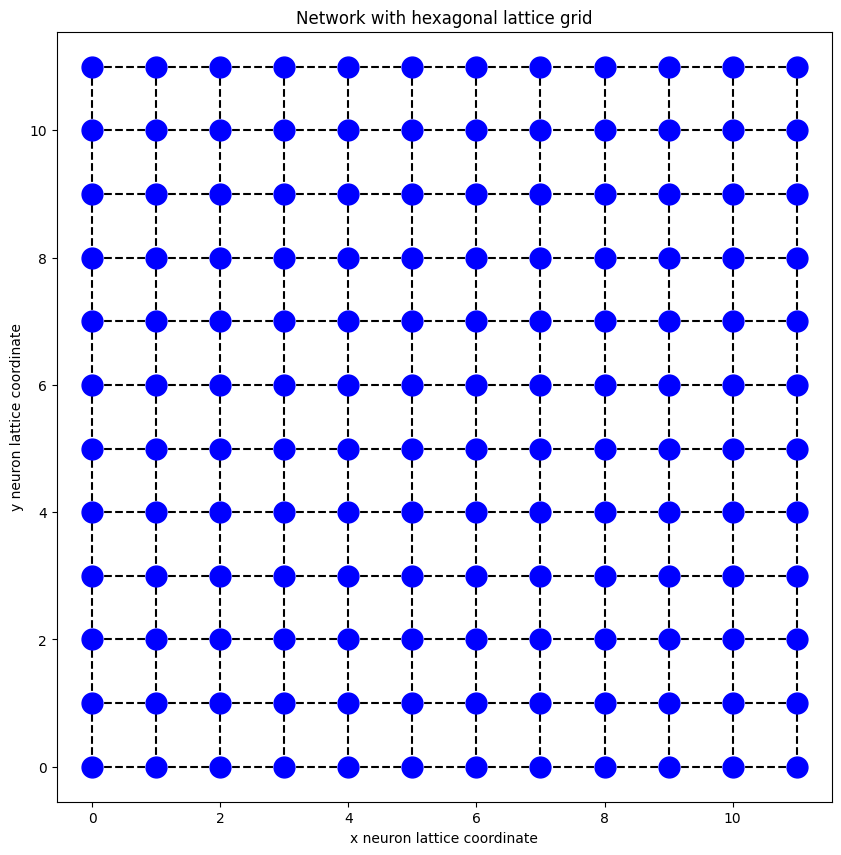

In [41]:
kochon = kohonen(12, 12, cube_x)
plot_lattice_grid(kochon)

In [22]:
M = 5
N = 4
index_array = np.array(
    [
        np.arange(M).repeat(N).reshape(M, N),
        np.arange(N).repeat(M).reshape(N, M).T,
    ],
    dtype=float,
)
index_array[0] = index_array[0] * np.sqrt(3) / 2
index_array[1][1::2] += 0.5
index_array

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.8660254 , 0.8660254 , 0.8660254 , 0.8660254 ],
        [1.73205081, 1.73205081, 1.73205081, 1.73205081],
        [2.59807621, 2.59807621, 2.59807621, 2.59807621],
        [3.46410162, 3.46410162, 3.46410162, 3.46410162]],

       [[0.        , 1.        , 2.        , 3.        ],
        [0.5       , 1.5       , 2.5       , 3.5       ],
        [0.        , 1.        , 2.        , 3.        ],
        [0.5       , 1.5       , 2.5       , 3.5       ],
        [0.        , 1.        , 2.        , 3.        ]]])

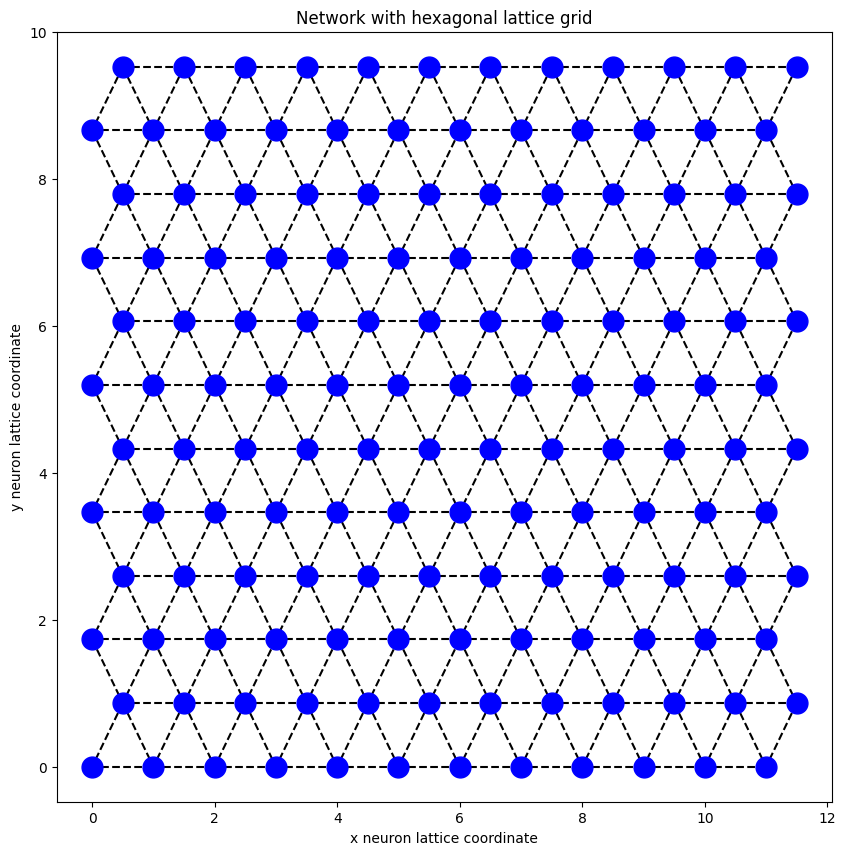

In [42]:
kochon = kohonen(12, 12, cube_x, lattice="hexagonal")
plot_lattice_grid(kochon)

In [68]:
ko = kohonen(9, 9, cube_x)
ko.train(cube_x, 1000, use_cache=True)

# speed comparison 

In [12]:
import time

unoptimized = []
optimized = []
optimized_cache = []
size = 4


for i in range(15):
    start = time.time()
    ko = kohonen_old(size, size, cube_x)
    ko.train(
        cube_x,
        10,
    )
    unoptimized.append((time.time() - start) / 10)

    start = time.time()
    ko = kohonen(size, size, cube_x)
    ko.train(cube_x, 10, verbose=False)
    optimized.append((time.time() - start) / 10)

    start = time.time()
    ko = kohonen(size, size, cube_x)
    ko.train(cube_x, 10, use_cache=True, verbose=False)
    optimized_cache.append((time.time() - start) / 10)

    print(f"finished: {i}")

finished: 0
finished: 1
finished: 2
finished: 3
finished: 4
finished: 5
finished: 6
finished: 7
finished: 8
finished: 9
finished: 10
finished: 11
finished: 12
finished: 13
finished: 14


Text(0.5, 1.0, 'Comparison of the training time per epoch on a 4x4 lattice')

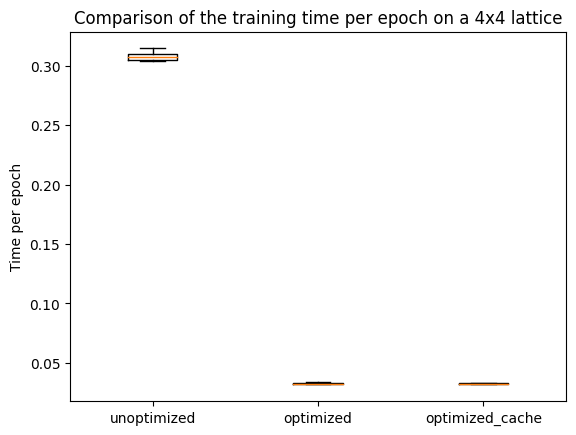

In [15]:
# make a boxplot
plt.boxplot(
    [unoptimized, optimized, optimized_cache],
    labels=["unoptimized", "optimized", "optimized_cache"],
)
plt.ylabel("Time per epoch")
plt.title("Comparison of the training time per epoch on a 4x4 lattice")

Text(0.5, 1.0, 'Comparison of the training time per epoch on a 4x4 lattice')

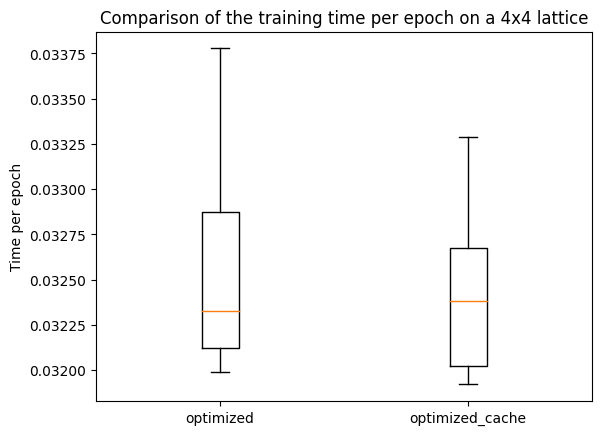

In [16]:
# comparison of just the optimized and optimized with cache
plt.boxplot(
    [optimized, optimized_cache],
    labels=["optimized", "optimized_cache"],
)
plt.ylabel("Time per epoch")
plt.title("Comparison of the training time per epoch on a 4x4 lattice")

In [17]:
import time

unoptimized = []
optimized = []
optimized_cache = []
size = 9


for i in range(15):
    start = time.time()
    ko = kohonen_old(size, size, cube_x)
    ko.train(
        cube_x,
        10,
    )
    unoptimized.append((time.time() - start) / 10)

    start = time.time()
    ko = kohonen(size, size, cube_x)
    ko.train(cube_x, 10, verbose=False)
    optimized.append((time.time() - start) / 10)

    start = time.time()
    ko = kohonen(size, size, cube_x)
    ko.train(cube_x, 10, use_cache=True, verbose=False)
    optimized_cache.append((time.time() - start) / 10)

    print(f"finished: {i}")

finished: 0
finished: 1
finished: 2
finished: 3
finished: 4
finished: 5
finished: 6
finished: 7
finished: 8
finished: 9
finished: 10
finished: 11
finished: 12
finished: 13
finished: 14


Text(0.5, 1.0, 'Comparison of the training time per epoch on a 9x9 lattice')

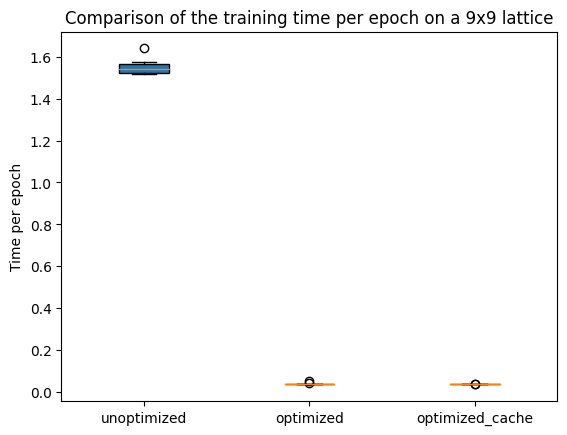

In [18]:
# make a boxplot
plt.boxplot(
    [unoptimized, optimized, optimized_cache],
    labels=["unoptimized", "optimized", "optimized_cache"],
    patch_artist=True,
)
plt.ylabel("Time per epoch")
plt.title("Comparison of the training time per epoch on a 9x9 lattice")

Text(0.5, 1.0, 'Comparison of the training time per epoch on a 9x9 lattice')

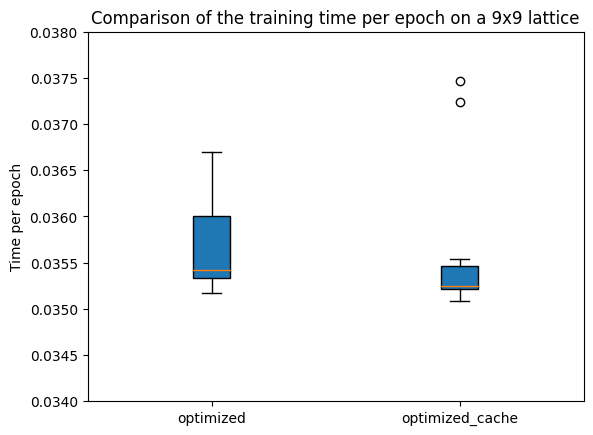

In [20]:
# comparison of just the optimized and optimized with cache
plt.boxplot(
    [optimized, optimized_cache],
    labels=["optimized", "optimized_cache"],
    patch_artist=True,
)
plt.ylim(0.034, 0.038)
plt.ylabel("Time per epoch")
plt.title("Comparison of the training time per epoch on a 9x9 lattice")

## Reading mnist

In [8]:
mnist_train = pd.read_csv("./../data/kohonen/mnist_train.csv", header=None)
mnist_train_x = mnist_train.drop(0, axis=1).to_numpy()
mnist_train_y = mnist_train[0].to_numpy()
mnist_test = pd.read_csv("./../data/kohonen/mnist_test.csv", header=None)
mnist_test_x = mnist_test.drop(0, axis=1).to_numpy()
mnist_test_y = mnist_test[0].to_numpy()

In [37]:
mnist_kohonen = kohonen(2, 5, mnist_train_x, learning_rate=0.05)
mnist_kohonen.train(mnist_train_x, 100, use_cache=True)

Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90


In [38]:
mnist_test_predicted = mnist_kohonen.predict(mnist_test_x)
v_measure_score(mnist_test_y, mnist_test_predicted.T[0])

0.48467069190971185